In [68]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import SnowballStemmer

import os
import itertools
import cv2
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,  BatchNormalization, Activation, Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

In [69]:
df = pd.read_csv('eye_disease_detection_dataset/archive/full_df.csv')
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [70]:
df.columns

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename'],
      dtype='object')

In [71]:
len(df)

6392

In [72]:
len(df[df.duplicated()])

0

In [73]:
df.isnull().sum()

ID                           0
Patient Age                  0
Patient Sex                  0
Left-Fundus                  0
Right-Fundus                 0
Left-Diagnostic Keywords     0
Right-Diagnostic Keywords    0
N                            0
D                            0
G                            0
C                            0
A                            0
H                            0
M                            0
O                            0
filepath                     0
labels                       0
target                       0
filename                     0
dtype: int64

In [74]:
photo_counts = df['Left-Fundus'].value_counts()

# Filter names that appear more than once
photo_more_than_once = photo_counts[photo_counts > 1].index.tolist()

print(len(photo_more_than_once))

photo_more_than_once[0]

3034


'0_left.jpg'

In [75]:
df[df['Left-Fundus'] == '4784_left.jpg']

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
3193,4784,58,Male,4784_left.jpg,4784_right.jpg,hypertensive retinopathy，age-related macular d...,hypertensive retinopathy，age-related macular d...,0,0,0,0,1,1,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['H'],"[0, 0, 0, 0, 0, 1, 0, 0]",4784_right.jpg
6391,4784,58,Male,4784_left.jpg,4784_right.jpg,hypertensive retinopathy，age-related macular d...,hypertensive retinopathy，age-related macular d...,0,0,0,0,1,1,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['H'],"[0, 0, 0, 0, 0, 1, 0, 0]",4784_left.jpg


In [76]:
df['labels'].value_counts()

df.value_counts

<bound method DataFrame.value_counts of         ID  Patient Age Patient Sex    Left-Fundus    Right-Fundus  \
0        0           69      Female     0_left.jpg     0_right.jpg   
1        1           57        Male     1_left.jpg     1_right.jpg   
2        2           42        Male     2_left.jpg     2_right.jpg   
3        4           53        Male     4_left.jpg     4_right.jpg   
4        5           50      Female     5_left.jpg     5_right.jpg   
...    ...          ...         ...            ...             ...   
6387  4686           63        Male  4686_left.jpg  4686_right.jpg   
6388  4688           42        Male  4688_left.jpg  4688_right.jpg   
6389  4689           54        Male  4689_left.jpg  4689_right.jpg   
6390  4690           57        Male  4690_left.jpg  4690_right.jpg   
6391  4784           58        Male  4784_left.jpg  4784_right.jpg   

                               Left-Diagnostic Keywords  \
0                                              cataract   
1

# Analysis
## Finding out inconsistencies

In [77]:
print(len(df[(df['labels'] == "['N']") & (df['N'] != 1)]))
print(len(df[(df['labels'] == "['D']") & (df['D'] != 1)]))
print(len(df[(df['labels'] == "['O']") & (df['O'] != 1)]))
print(len(df[(df['labels'] == "['C']") & (df['C'] != 1)]))
print(len(df[(df['labels'] == "['G']") & (df['G'] != 1)]))
print(len(df[(df['labels'] == "['A']") & (df['A'] != 1)]))
print(len(df[(df['labels'] == "['M']") & (df['M'] != 1)]))
print(len(df[(df['labels'] == "['H']") & (df['H'] != 1)]))

772
0
3
0
0
0
0
0


In [78]:
df.drop(columns=[ 'ID'] , inplace=True)

In [79]:
len(df[df['Patient Age'] == 1])

28

In [80]:
def update_labels(row):
    
    new_label = ''
    for col in df.columns:
        if row[col] == 1 and col != 'Patient Age':
            new_label = new_label + col
    row['labels'] = new_label      
    return row

df = df.apply(update_labels, axis=1)

In [81]:
df['labels'].nunique()

37

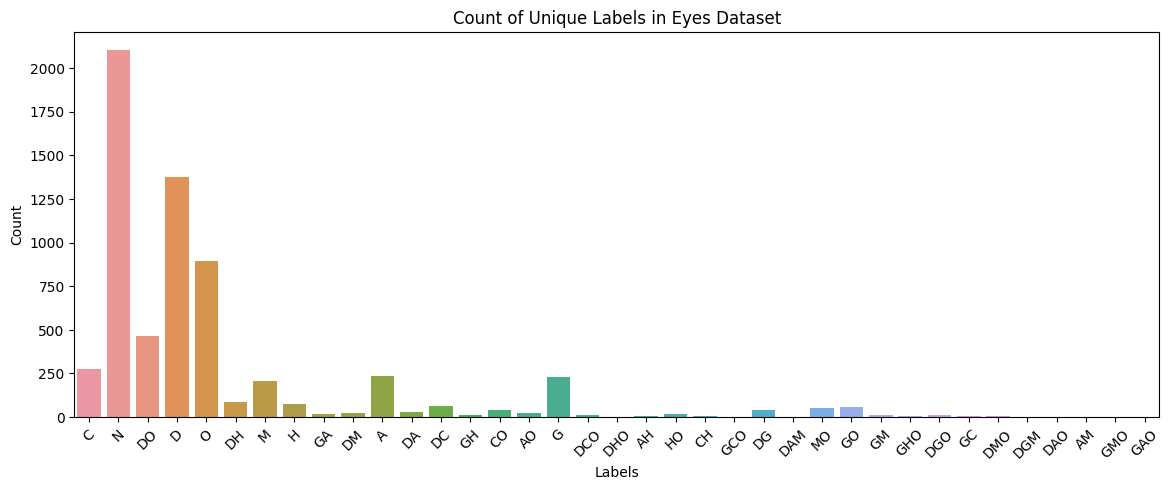

In [82]:
plt.figure(figsize=(14, 5))
sns.countplot(x='labels', data=df , orient='h')
plt.title('Count of Unique Labels in Eyes Dataset')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [83]:
df[df['Left-Diagnostic Keywords'] == 'low image quality']

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
2547,45,Male,3935_left.jpg,3935_right.jpg,low image quality,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",3935_right.jpg
2606,71,Male,4007_left.jpg,4007_right.jpg,low image quality,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4007_right.jpg
2744,48,Male,4169_left.jpg,4169_right.jpg,low image quality,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4169_right.jpg
2854,51,Male,4290_left.jpg,4290_right.jpg,low image quality,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",4290_right.jpg
2989,62,Female,4442_left.jpg,4442_right.jpg,low image quality,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4442_right.jpg
2994,50,Male,4448_left.jpg,4448_right.jpg,low image quality,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4448_right.jpg
3053,67,Male,4522_left.jpg,4522_right.jpg,low image quality,severe nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4522_right.jpg


In [84]:
df[df['Right-Diagnostic Keywords'] == 'low image quality']

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
3517,52,Female,372_left.jpg,372_right.jpg,"low image quality,maculopathy",low image quality,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,O,"[0, 0, 0, 0, 0, 0, 0, 1]",372_left.jpg
5748,62,Male,3947_left.jpg,3947_right.jpg,moderate non proliferative retinopathy,low image quality,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",3947_left.jpg
5848,80,Female,4066_left.jpg,4066_right.jpg,moderate non proliferative retinopathy,low image quality,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4066_left.jpg
5901,43,Male,4124_left.jpg,4124_right.jpg,moderate non proliferative retinopathy,low image quality,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4124_left.jpg
5947,63,Male,4180_left.jpg,4180_right.jpg,moderate non proliferative retinopathy,low image quality,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4180_left.jpg
5963,58,Female,4198_left.jpg,4198_right.jpg,moderate non proliferative retinopathy,low image quality,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4198_left.jpg
6025,60,Male,4262_left.jpg,4262_right.jpg,mild nonproliferative retinopathy,low image quality,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4262_left.jpg
6080,69,Male,4319_left.jpg,4319_right.jpg,moderate non proliferative retinopathy,low image quality,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4319_left.jpg
6146,56,Male,4394_left.jpg,4394_right.jpg,mild nonproliferative retinopathy,low image quality,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4394_left.jpg
6176,43,Male,4427_left.jpg,4427_right.jpg,mild nonproliferative retinopathy,low image quality,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4427_left.jpg


In [85]:
df = df.loc[(df['Left-Diagnostic Keywords'] != 'low image quality')]
df = df.loc[(df['Right-Diagnostic Keywords'] != 'low image quality')]

In [86]:

print(len(df[(df['labels'] == "['N']") & (df['N'] != 1)]))
print(len(df[(df['labels'] == "['O']") & (df['O'] != 1)]))
df.head()

0
0


,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,C,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,DO,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,DO,"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [87]:
print(len(df[(df['labels'] == "['N']") & (df['N'] != 1)]))
print(len(df[(df['labels'] == "['O']") & (df['O'] != 1)]))
df.head()

0
0


,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,C,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,DO,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,DO,"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [88]:
photos_unique = df.drop_duplicates(subset='Left-Fundus', keep='first')
df = photos_unique
df.reset_index(drop=True,inplace=True)
len(df)

3340

In [89]:
# Checking unique values
df['Left-Diagnostic Keywords'].nunique()

194

In [90]:
# Checking unique values
df['Right-Diagnostic Keywords'].nunique()


204

In [91]:
# Checking which values appear the most
df['Left-Diagnostic Keywords'].mode()

0    normal fundus
Name: Left-Diagnostic Keywords, dtype: object

In [92]:
# Checking count of each unique value
df['Left-Diagnostic Keywords'].value_counts()

Left-Diagnostic Keywords
normal fundus                                    1433
moderate non proliferative retinopathy            359
mild nonproliferative retinopathy                 217
cataract                                          135
pathological myopia                               111
                                                 ... 
drusen，cataract，lens dust                           1
optic disk epiretinal membrane                      1
pigment epithelium proliferation                    1
laser spot，mild nonproliferative retinopathy        1
glaucoma，wet age-related macular degeneration       1
Name: count, Length: 194, dtype: int64

In [93]:
# Checking normal fundus count as it appears most of the times
len(df[df['Left-Diagnostic Keywords'] == 'normal fundus'])

1433

In [94]:
# Checking which values appear the most
df['Right-Diagnostic Keywords'].mode()

0    normal fundus
Name: Right-Diagnostic Keywords, dtype: object

In [95]:
# Checking the count of the normal fundus for right eye
len(df[df['Right-Diagnostic Keywords'] == 'normal fundus'])

1382

In [96]:
# Creating new df for the patients with both eyes normal 

both_eyes_normal = df[
    (df['Right-Diagnostic Keywords'] == 'normal fundus') & 
    (df['Left-Diagnostic Keywords'] == 'normal fundus')
]

both_eyes_normal.reset_index(inplace=True,drop=True)

len(both_eyes_normal)

1001

In [97]:
# Creating new df for the patients with both eyes NOT normal 

both_eyes_not_normal = df[
    (df['Right-Diagnostic Keywords'] != 'normal fundus') & 
    (df['Left-Diagnostic Keywords'] != 'normal fundus')
]

both_eyes_not_normal.reset_index(inplace=True,drop=True)

len(both_eyes_not_normal)

1526

In [98]:
# Checking count for normal right eye

left_eye_abnormalities = df[
    (df['Right-Diagnostic Keywords'] == 'normal fundus') & 
    (df['Left-Diagnostic Keywords'] != 'normal fundus')
]

left_eye_abnormalities.reset_index(inplace=True,drop=True)

In [99]:

len(left_eye_abnormalities)

381

In [100]:
left_eye_abnormalities[(left_eye_abnormalities['labels'] == 'N')].head(5)

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
269,68,Male,2400_left.jpg,2400_right.jpg,lens dust，normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2400_right.jpg
270,33,Male,2483_left.jpg,2483_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2483_right.jpg
271,50,Female,2486_left.jpg,2486_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2486_right.jpg
272,68,Female,2495_left.jpg,2495_right.jpg,lens dust，normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2495_right.jpg
273,52,Female,2496_left.jpg,2496_right.jpg,lens dust，normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2496_right.jpg


In [101]:
# Checking count for right eye abnormalities

right_eye_abnormalities = df[
    (df['Right-Diagnostic Keywords'] != 'normal fundus') & 
    (df['Left-Diagnostic Keywords'] == 'normal fundus')
]

right_eye_abnormalities.reset_index(inplace=True,drop=True)

len(right_eye_abnormalities)

432

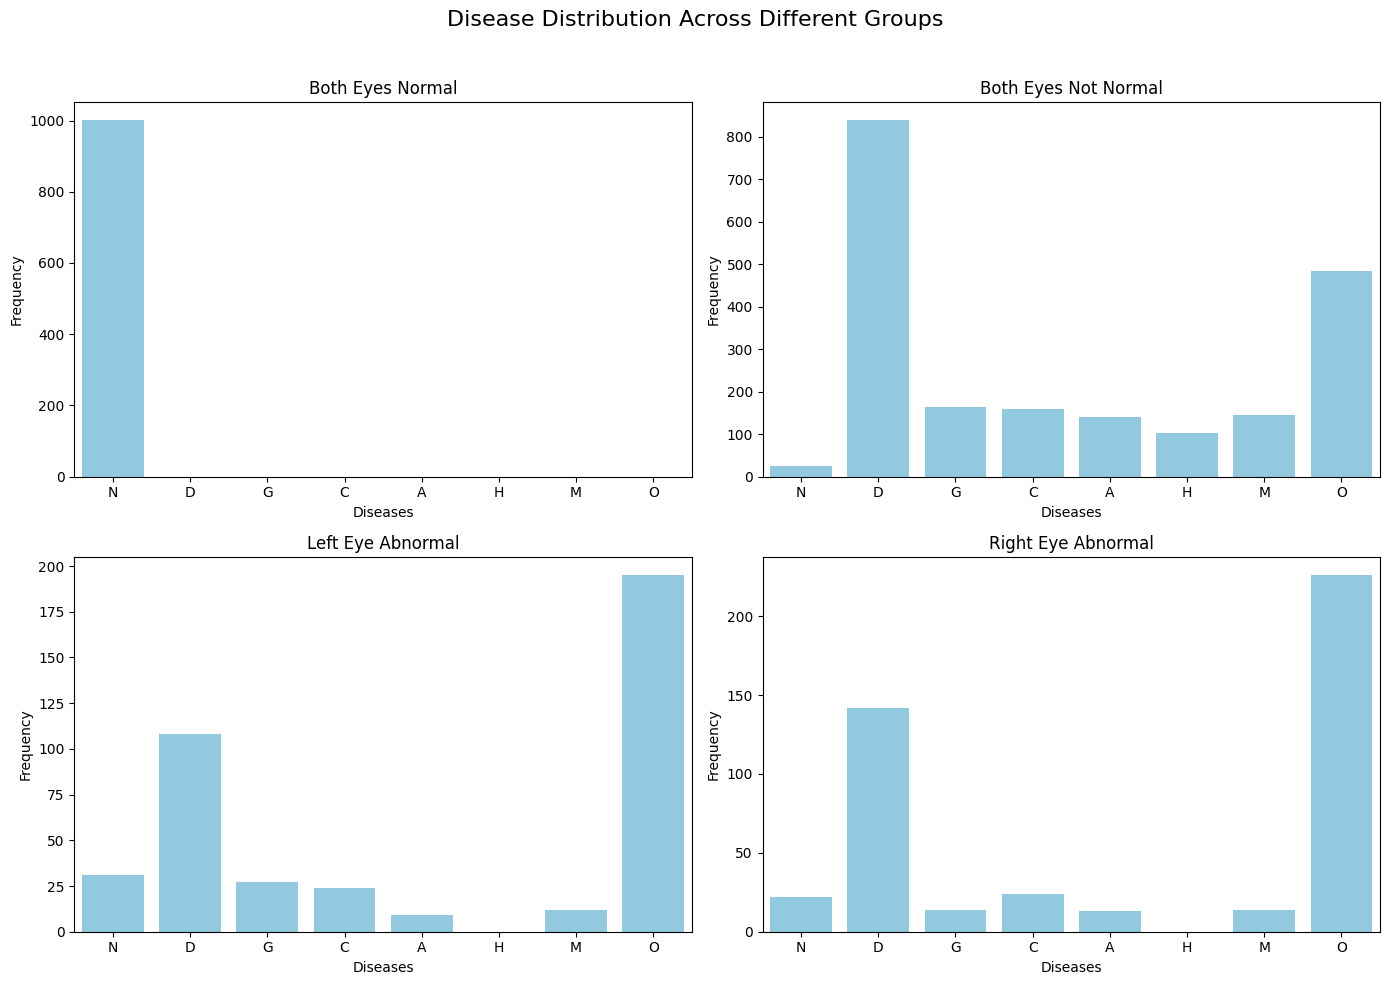

In [102]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Disease Distribution Across Different Groups', fontsize=16)

# Define titles for the subplots
titles = [
    'Both Eyes Normal',
    'Both Eyes Not Normal',
    'Left Eye Abnormal',
    'Right Eye Abnormal'
]

# Create a list of DataFrames
dataframes = [both_eyes_normal, both_eyes_not_normal, left_eye_abnormalities, right_eye_abnormalities]

# Loop through DataFrames and plot on subplots
for df, ax, title in zip(dataframes, axes.ravel(), titles):
    disease_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    disease_counts = df[disease_columns].sum()
    
    sns.barplot(x=disease_counts.index, y=disease_counts.values, color='skyblue', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Diseases')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [103]:
len(both_eyes_normal)

1001

In [104]:
# Added additional normal values which was leaking into not normal df to the normal eyes df 

filtered_df = both_eyes_not_normal[both_eyes_not_normal['N'] == 1]

both_eyes_normal = pd.concat(
    [both_eyes_normal[both_eyes_normal['N'].isin(filtered_df['N'])], filtered_df],
    axis=0, ignore_index=True
).drop_duplicates()

In [105]:
len(both_eyes_normal)

1026

In [106]:
# Keeping only abnormal eyes 
both_eyes_not_normal = both_eyes_not_normal.loc[~(both_eyes_not_normal['N'] == 1)]

In [107]:
# Remove normal left eye fundus values wrongly flagged as abnormal due to "lens dust" 
# and move them to the both eyes' normal DataFrame.

left_eye_abnormalities[left_eye_abnormalities['N'] == 1]

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
269,68,Male,2400_left.jpg,2400_right.jpg,lens dust，normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2400_right.jpg
270,33,Male,2483_left.jpg,2483_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2483_right.jpg
271,50,Female,2486_left.jpg,2486_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2486_right.jpg
272,68,Female,2495_left.jpg,2495_right.jpg,lens dust，normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2495_right.jpg
273,52,Female,2496_left.jpg,2496_right.jpg,lens dust，normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2496_right.jpg
274,72,Female,2509_left.jpg,2509_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2509_right.jpg
275,62,Female,2566_left.jpg,2566_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2566_right.jpg
276,34,Male,2629_left.jpg,2629_right.jpg,lens dust，normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2629_right.jpg
277,49,Female,2652_left.jpg,2652_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2652_right.jpg
278,45,Female,2661_left.jpg,2661_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2661_right.jpg


In [108]:
filtered_df = left_eye_abnormalities[left_eye_abnormalities['N'] == 1]

both_eyes_normal = pd.concat(
    [both_eyes_normal[both_eyes_normal['N'].isin(filtered_df['N'])], filtered_df],
    axis=0, ignore_index=True
).drop_duplicates()

In [109]:
# Filter out left eye normal fundus values mistakenly flagged as abnormalities.
left_eye_abnormalities = left_eye_abnormalities.loc[~(left_eye_abnormalities['N'] == 1)]

In [110]:
# Checking vice versa with the right eye abnormilities
right_eye_abnormalities[right_eye_abnormalities['N'] == 1]

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
241,46,Female,2370_left.jpg,2370_right.jpg,normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2370_right.jpg
242,69,Male,2520_left.jpg,2520_right.jpg,normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2520_right.jpg
243,51,Male,2954_left.jpg,2954_right.jpg,normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2954_right.jpg
244,63,Female,3283_left.jpg,3283_right.jpg,normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",3283_right.jpg
412,51,Male,2377_left.jpg,2377_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2377_left.jpg
413,56,Male,2448_left.jpg,2448_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2448_left.jpg
414,39,Male,2515_left.jpg,2515_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2515_left.jpg
415,75,Male,2724_left.jpg,2724_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2724_left.jpg
416,66,Male,2727_left.jpg,2727_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2727_left.jpg
417,62,Female,2729_left.jpg,2729_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2729_left.jpg


In [111]:
# Appending it to both eye normal df
filtered_df = right_eye_abnormalities[right_eye_abnormalities['N'] == 1]

both_eyes_normal = pd.concat(
    [both_eyes_normal[both_eyes_normal['N'].isin(filtered_df['N'])], filtered_df],
    axis=0, ignore_index=True
).drop_duplicates()

In [112]:
# Filter out right eye normal fundus values mistakenly flagged as abnormalities.
right_eye_abnormalities = right_eye_abnormalities.loc[~(right_eye_abnormalities['N'] == 1)]

In [113]:
len(both_eyes_normal)

1079

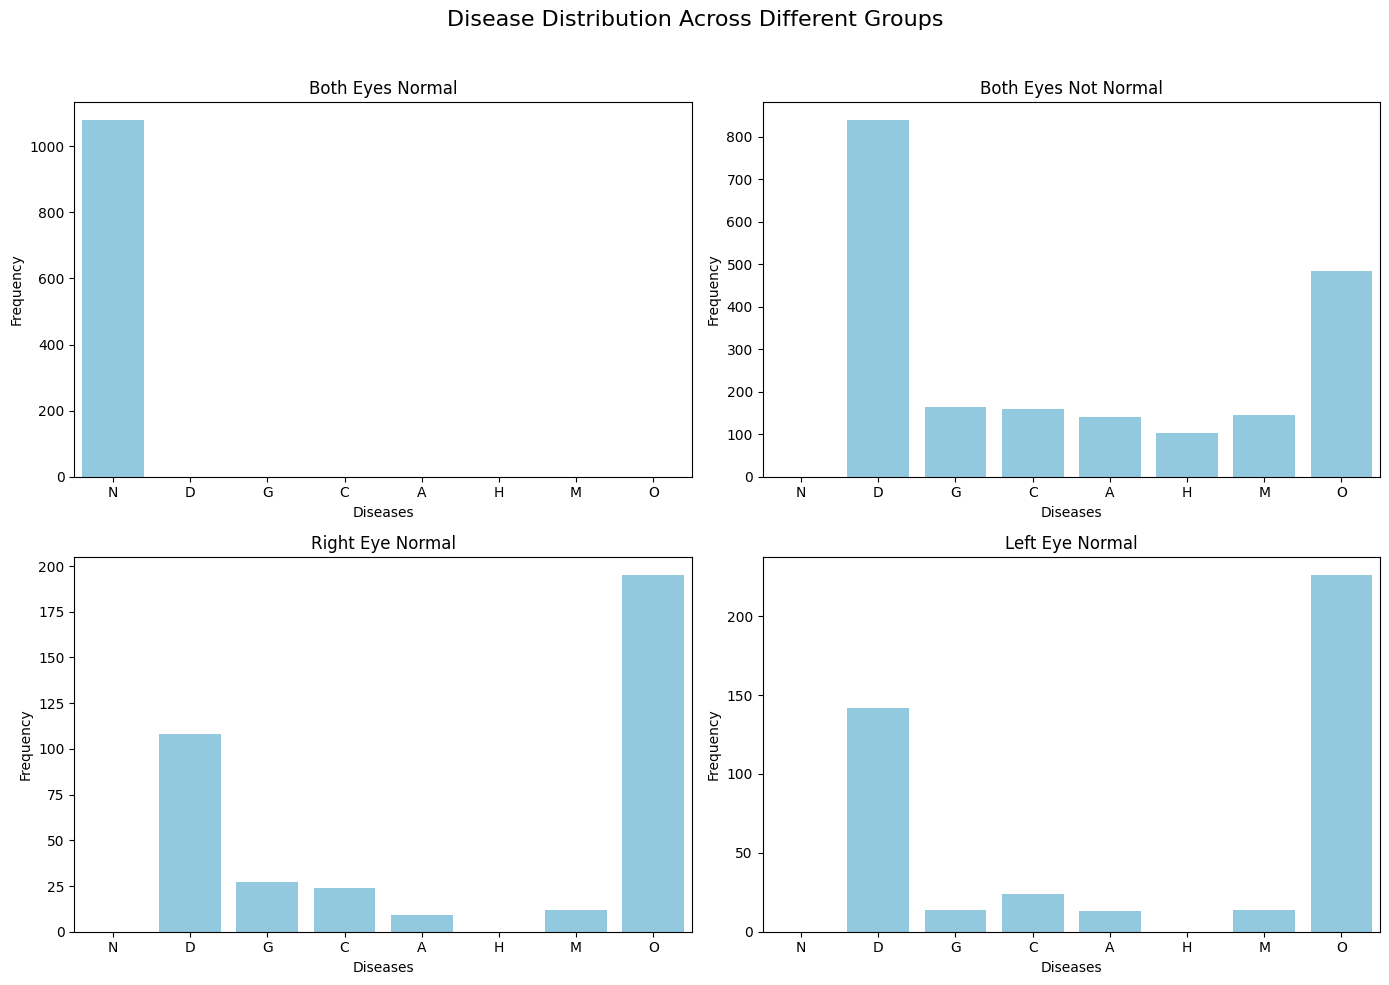

In [114]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Disease Distribution Across Different Groups', fontsize=16)

# Define titles for the subplots
titles = [
    'Both Eyes Normal',
    'Both Eyes Not Normal',
    'Right Eye Normal',
    'Left Eye Normal'
]

# Create a list of DataFrames
dataframes = [both_eyes_normal, both_eyes_not_normal, left_eye_abnormalities, right_eye_abnormalities]

# Loop through DataFrames and plot on subplots
for df, ax, title in zip(dataframes, axes.ravel(), titles):
    disease_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    disease_counts = df[disease_columns].sum()
    
    sns.barplot(x=disease_counts.index, y=disease_counts.values, color='skyblue', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Diseases')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [115]:
len(df)

410

In [116]:
df = pd.concat([left_eye_abnormalities, right_eye_abnormalities, both_eyes_not_normal, both_eyes_normal], ignore_index=True, sort=False)

In [117]:
len(df)

3340

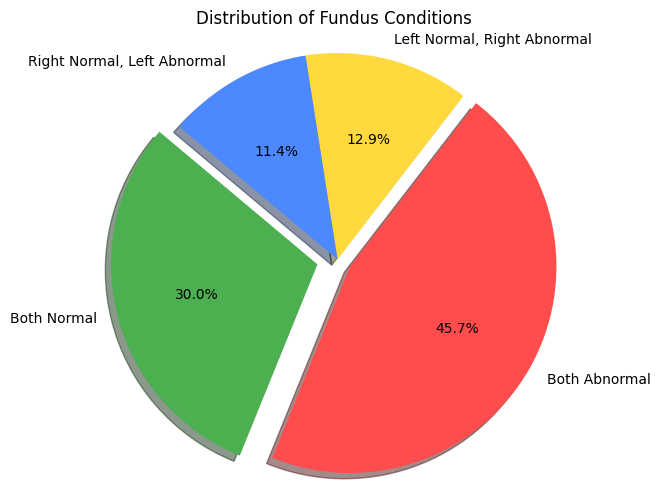

In [118]:
condition_normal_left = df['Left-Diagnostic Keywords'] == 'normal fundus'
condition_normal_right = df['Right-Diagnostic Keywords'] == 'normal fundus'

# Determine the categories
both_normal = (condition_normal_left) & (condition_normal_right)
both_abnormal = (~condition_normal_left) & (~condition_normal_right)
left_normal_right_abnormal = (condition_normal_left) & (~condition_normal_right)
right_normal_left_abnormal = (~condition_normal_left) & (condition_normal_right)

# Count occurrences for each category
counts = {
    'Both Normal': both_normal.sum(),
    'Both Abnormal': both_abnormal.sum(),
    'Left Normal, Right Abnormal': left_normal_right_abnormal.sum(),
    'Right Normal, Left Abnormal': right_normal_left_abnormal.sum()
}

# Create a pie chart
labels = counts.keys()
sizes = counts.values()
colors = ['#4CAF50','#FF4C4C','#FFD93D','#4C89FF']
explode = (0.1, 0.07, 0, 0)  # explode the 1st slice (optional)

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Fundus Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

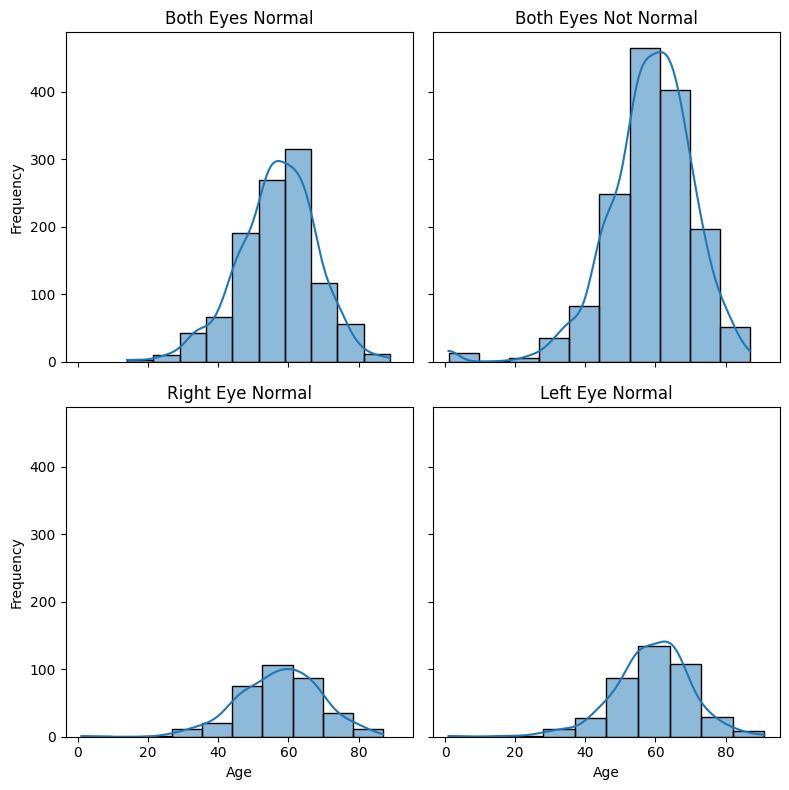

In [119]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.flatten()  # Converts 2x2 array to 1D array [0,1,2,3]

for i, (eyes, title) in enumerate(zip(dataframes, titles)):
    sns.histplot(eyes['Patient Age'], kde=True, bins=10, ax=axes[i])
    axes[i].set_title(title)
    axes[i].set_xlabel('Age')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

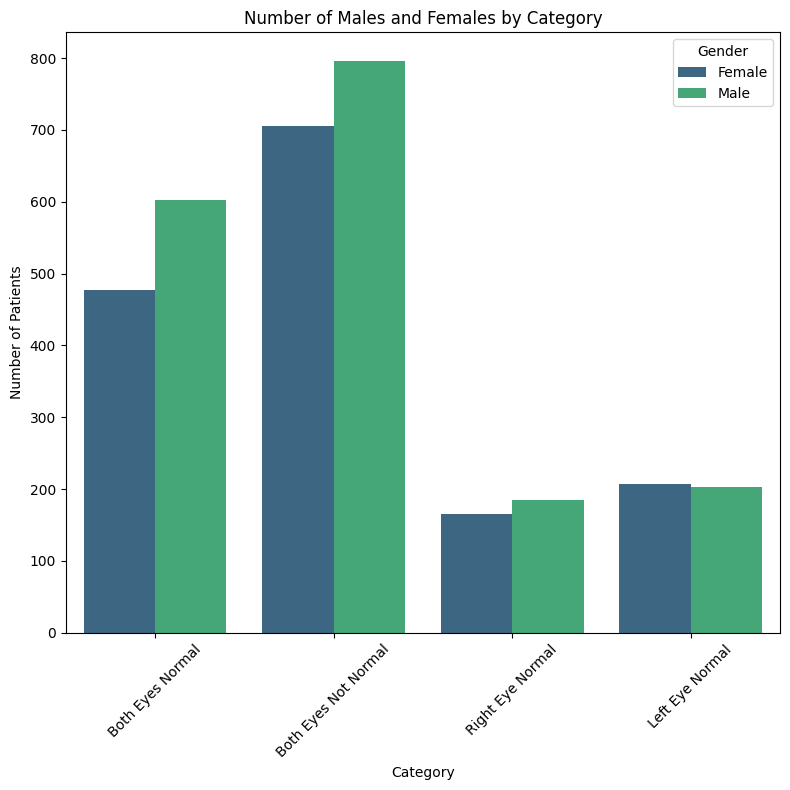

In [120]:
counts = {
    'Both Eyes Normal': both_eyes_normal['Patient Sex'].value_counts(),
    'Both Eyes Not Normal': both_eyes_not_normal['Patient Sex'].value_counts(),
    'Right Eye Normal': left_eye_abnormalities['Patient Sex'].value_counts(),
    'Left Eye Normal': right_eye_abnormalities['Patient Sex'].value_counts()
}

# Convert to DataFrame for easy plotting
plot_data = pd.DataFrame(counts).fillna(0).T.reset_index()
plot_data = plot_data.melt(id_vars='index', var_name='Gender', value_name='Count')
plot_data = plot_data.rename(columns={'index': 'Category'})

# Create the bar plot
plt.figure(figsize=(8, 8))
sns.barplot(data=plot_data, x='Category', y='Count', hue='Gender', palette='viridis')

plt.title('Number of Males and Females by Category')
plt.xlabel('Category')
plt.ylabel('Number of Patients')
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

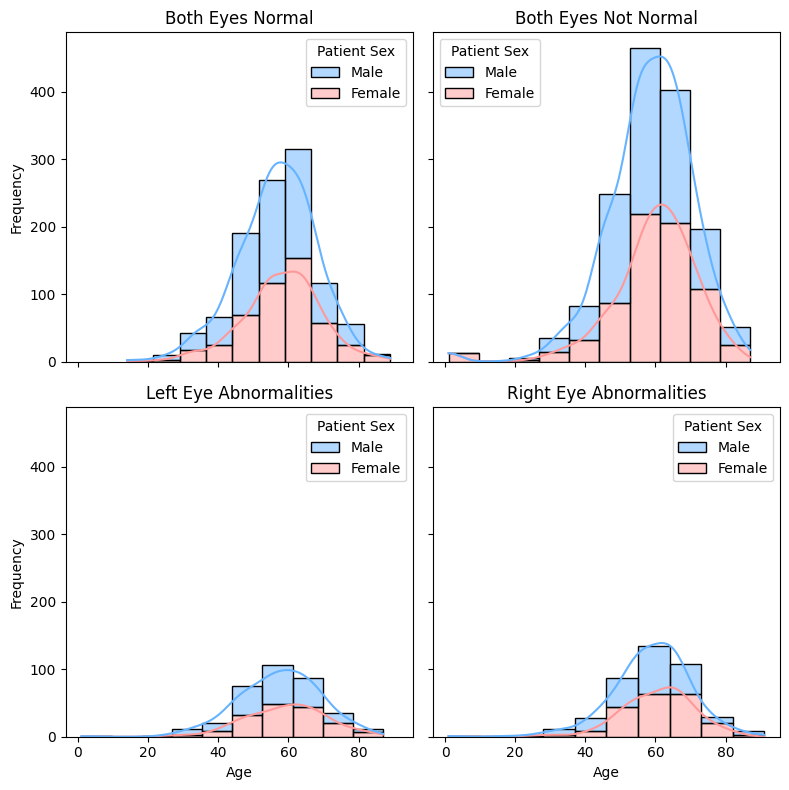

In [121]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.flatten()

dataframes = [both_eyes_normal, both_eyes_not_normal, left_eye_abnormalities, right_eye_abnormalities]
titles = ['Both Eyes Normal', 'Both Eyes Not Normal', 'Left Eye Abnormalities', 'Right Eye Abnormalities']
colors = ['#66b3ff', '#ff9999']  # blue for Male, pink for Female

# Plot each dataframe
for i, (eyes, title) in enumerate(zip(dataframes, titles)):
    sns.histplot(eyes, x='Patient Age', hue='Patient Sex', 
                hue_order=['Male', 'Female'],
                multiple='stack', palette=colors, bins=10, 
                ax=axes[i], kde=True)
    axes[i].set_title(title)
    axes[i].set_xlabel('Age')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

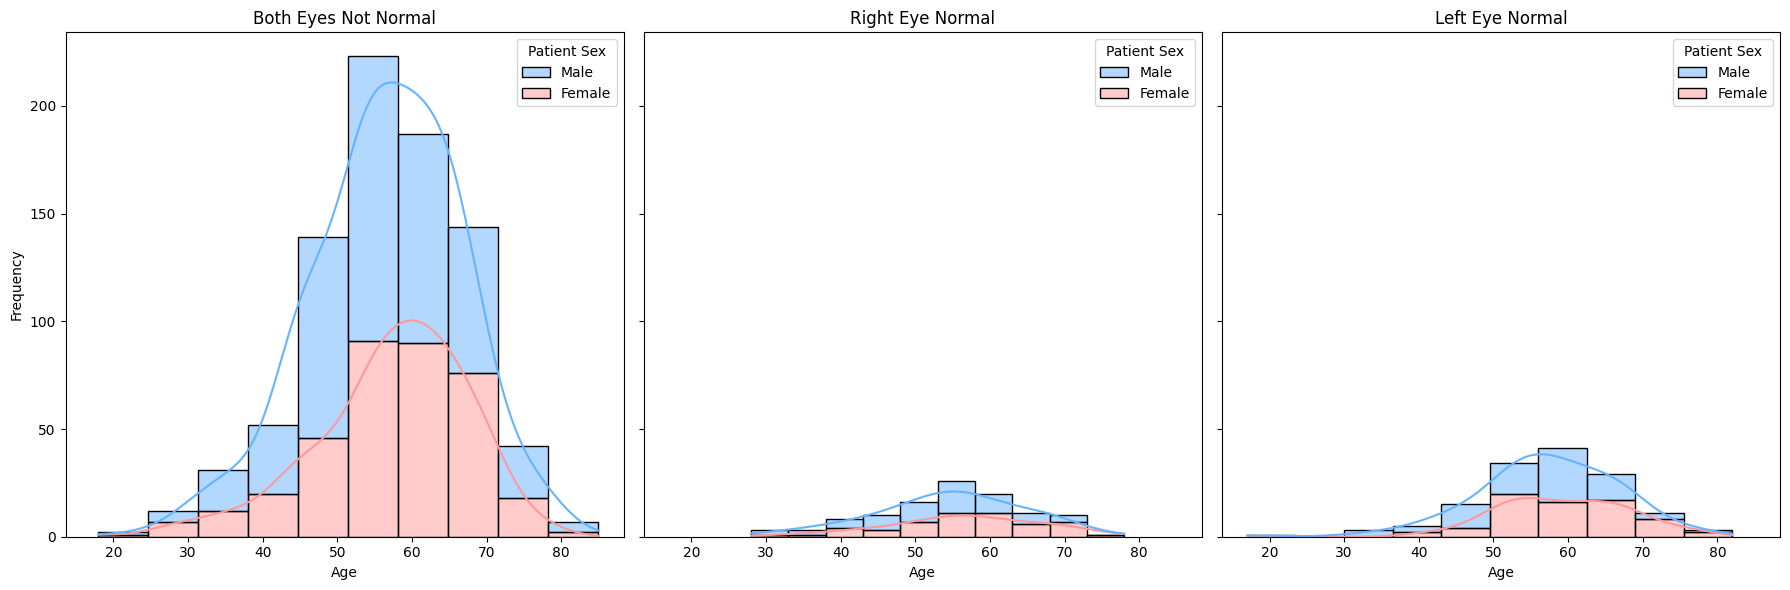

In [122]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

dataframes = [both_eyes_not_normal, left_eye_abnormalities, right_eye_abnormalities]

titles = ['Both Eyes Not Normal', 'Right Eye Normal', 'Left Eye Normal']
colors = ['#66b3ff', '#ff9999']

# Plot each dataframe with condition D = 1 applied within the loop
for i, (eyes, title) in enumerate(zip(dataframes, titles)):
    row = i // 3
    col = i % 3
    filtered_df = eyes.query('D == 1')
    if not filtered_df.empty:
        sns.histplot(filtered_df, x='Patient Age', hue='Patient Sex', hue_order=['Male', 'Female'], multiple='stack', palette=colors, bins=10, ax=axes[col], kde=True)
    axes[col].set_title(title)
    axes[col].set_xlabel('Age')
    axes[col].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

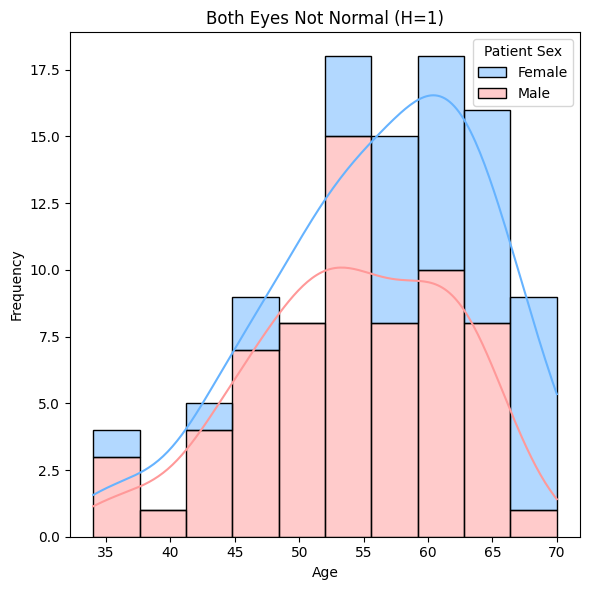

In [123]:
fig, ax = plt.subplots(figsize=(6, 6))

# Define the DataFrame and title
eyes = both_eyes_not_normal
title = 'Both Eyes Not Normal (H=1)'
colors = ['#66b3ff', '#ff9999']

# Filter data for H = 1 and plot
filtered_df = eyes.query('H == 1')
if not filtered_df.empty:
    sns.histplot(filtered_df, x='Patient Age', hue='Patient Sex', multiple='stack', palette=colors, bins=10, ax=ax, kde=True)
    ax.set_title(title)
    ax.set_xlabel('Age')
    ax.set_ylabel('Frequency')
else:
    ax.text(0.5, 0.5, 'No data available for H = 1', horizontalalignment='center', verticalalignment='center', fontsize=14, color='red')

# Adjust layout
plt.tight_layout()
plt.show()

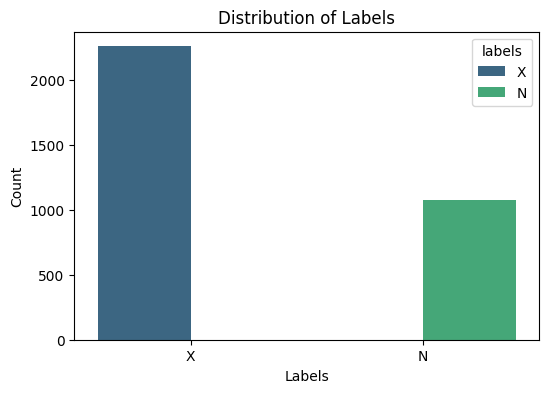

In [ ]:
df.loc[df['labels'] != 'N', 'labels'] = 'X'

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='labels', hue='labels', palette='viridis')

plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')

plt.show()

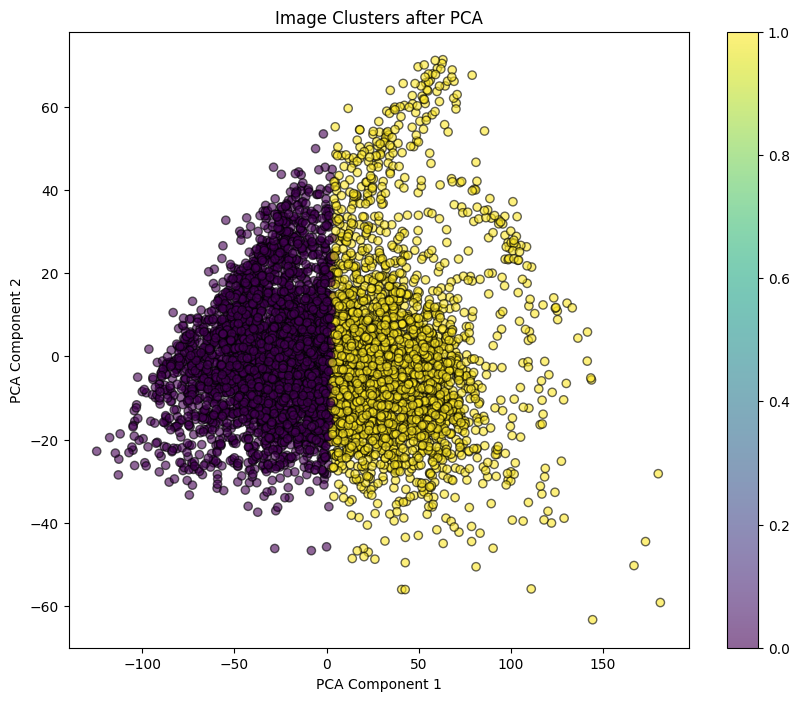

In [125]:
train_dir = "eye_disease_detection_dataset/archive/preprocessed_images"

file_paths = []
features = []

for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.endswith(('jpg', 'png', 'jpeg')):
            file_path = os.path.join(root, file)
            file_paths.append(file_path)
            
            image = cv2.imread(file_path)
            image = cv2.resize(image, (100, 100)) 
            avg_color = image.mean(axis=0).mean(axis=0)  
            features.append(avg_color)

features = np.array(features)

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(reduced_features)

eyes = pd.DataFrame({
    'file_path': file_paths,
    'PCA1': reduced_features[:, 0],
    'PCA2': reduced_features[:, 1],
    'cluster': clusters
})


plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', alpha=0.6, edgecolor='k')
plt.title("Image Clusters after PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar()
plt.show()

In [126]:
eyes.head()

,file_path,PCA1,PCA2,cluster
0,eye_disease_detection_dataset/archive/preproce...,-8.073268,-18.507972,0
1,eye_disease_detection_dataset/archive/preproce...,-57.681722,-13.303427,0
2,eye_disease_detection_dataset/archive/preproce...,25.952066,-1.801106,1
3,eye_disease_detection_dataset/archive/preproce...,-88.134020,-21.661711,0
4,eye_disease_detection_dataset/archive/preproce...,-67.614146,-15.359982,0


In [127]:
eyes['cluster'].value_counts()

cluster
0    3455
1    2937
Name: count, dtype: int64

In [128]:
eyes.drop(columns = ['PCA1' , 'PCA2'], axis=1 , inplace = True)

In [129]:
eyes.head()

,file_path,cluster
0,eye_disease_detection_dataset/archive/preproce...,0
1,eye_disease_detection_dataset/archive/preproce...,0
2,eye_disease_detection_dataset/archive/preproce...,1
3,eye_disease_detection_dataset/archive/preproce...,0
4,eye_disease_detection_dataset/archive/preproce...,0


In [130]:
eyes['cluster'].value_counts()

cluster
0    3455
1    2937
Name: count, dtype: int64

In [131]:
eyes['cluster'] = eyes['cluster'].replace({0: 'X', 1: 'N'})

In [132]:
train_data, test = train_test_split(eyes, test_size=0.4, random_state=42, stratify=eyes['cluster'])
test, valid_data = train_test_split(test, test_size=0.5, random_state=42, stratify=test['cluster'])

print(f"Training set shape: {train_data.shape}")
print(f"Validation set shape: {valid_data.shape}")
print(f"Testing set shape: {test.shape}")

Training set shape: (3835, 2)
Validation set shape: (1279, 2)
Testing set shape: (1278, 2)


In [133]:
train_datagen = ImageDataGenerator(rescale=1./255 )

# Create an ImageDataGenerator for validation and test data (no data augmentation)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Specify the input size expected by the model
input_size = (224, 224)

# Create data generators for training, validation, and testing
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='file_path',
    y_col='cluster',
    target_size=input_size,
    shuffle = True, 
    batch_size=16,
    class_mode='categorical',  
    color_mode = 'rgb'
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=valid_data,
    x_col='file_path',
    y_col='cluster',
     target_size=input_size,
    shuffle = True, 
    batch_size=16,
    class_mode='categorical',
    color_mode = 'rgb'
)

test_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='file_path',
    y_col='cluster',
    target_size=input_size,
    shuffle=False,  
    batch_size=16,
    class_mode='categorical',
    color_mode = 'rgb'
)

Found 3835 validated image filenames belonging to 2 classes.
Found 1279 validated image filenames belonging to 2 classes.
Found 1278 validated image filenames belonging to 2 classes.


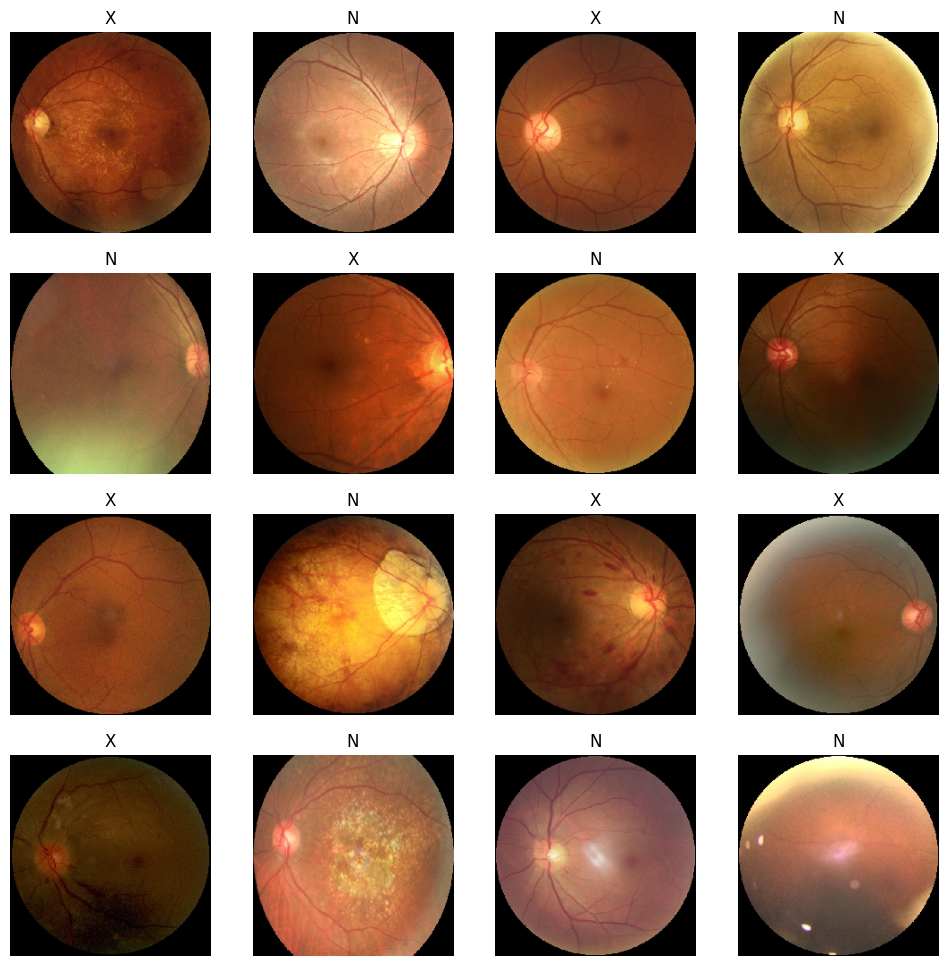

In [134]:
sample_images, sample_labels = next(train_generator)

# Display the images and labels
plt.figure(figsize=(12, 12))
for i in range(16):
    image = sample_images[i]
    label_index = np.argmax(sample_labels[i]) 
    label = list(train_generator.class_indices.keys())[label_index]  

    plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(label, color='k', fontsize=12)
    plt.axis("off")

plt.show()

In [ ]:
input_shape = (224, 224, 3)

model = Sequential()
# First Network
model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second block
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third block
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer=Adamax(learning_rate=0.002),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 56, 56, 128)       0

In [136]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('brain_tumors/best_model.keras', save_best_only=True)

In [137]:
history = model.fit(train_generator, epochs=20, validation_data=valid_generator,
                    validation_steps = None , shuffle = False,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
240/240 [==============================] - 701s 3s/step - loss: 0.6811 - accuracy: 0.8618 - val_loss: 0.2022 - val_accuracy: 0.9719
Epoch 2/20
240/240 [==============================] - 633s 3s/step - loss: 0.2432 - accuracy: 0.9322 - val_loss: 0.2389 - val_accuracy: 0.9156
Epoch 3/20
240/240 [==============================] - 618s 3s/step - loss: 0.2059 - accuracy: 0.9403 - val_loss: 0.2680 - val_accuracy: 0.8851
Epoch 4/20
240/240 [==============================] - 623s 3s/step - loss: 0.2014 - accuracy: 0.9429 - val_loss: 0.1264 - val_accuracy: 0.9687
Epoch 5/20
240/240 [==============================] - 645s 3s/step - loss: 0.1868 - accuracy: 0.9419 - val_loss: 0.3026 - val_accuracy: 0.8624
Epoch 6/20
240/240 [==============================] - 624s 3s/step - loss: 0.1939 - accuracy: 0.9392 - val_loss: 0.3818 - val_accuracy: 0.8538
Epoch 7/20
240/240 [==============================] - 640s 3s/step - loss: 0.1617 - accuracy: 0.9538 - val_loss: 0.1325 - val_accuracy: 0.9648

In [140]:
input_shape = (224, 224, 3)

model = Sequential()
# First block
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second block
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third block
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Dense layers
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer=Adamax(learning_rate=0.002),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 56, 56, 64)       

In [141]:
history = model.fit(train_generator, epochs=20, validation_data=valid_generator,
                    validation_steps = None , shuffle = False,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
240/240 [==============================] - 231s 959ms/step - loss: 0.4832 - accuracy: 0.8581 - val_loss: 0.1988 - val_accuracy: 0.9515
Epoch 2/20
240/240 [==============================] - 228s 952ms/step - loss: 0.2323 - accuracy: 0.9283 - val_loss: 0.3085 - val_accuracy: 0.8780
Epoch 3/20
240/240 [==============================] - 228s 950ms/step - loss: 0.2171 - accuracy: 0.9272 - val_loss: 0.1475 - val_accuracy: 0.9695
Epoch 4/20
240/240 [==============================] - 228s 951ms/step - loss: 0.1823 - accuracy: 0.9473 - val_loss: 0.1384 - val_accuracy: 0.9648
Epoch 5/20
240/240 [==============================] - 228s 951ms/step - loss: 0.1753 - accuracy: 0.9460 - val_loss: 0.2602 - val_accuracy: 0.8898
Epoch 6/20
240/240 [==============================] - 228s 950ms/step - loss: 0.1472 - accuracy: 0.9598 - val_loss: 0.1085 - val_accuracy: 0.9805
Epoch 7/20
240/240 [==============================] - 227s 946ms/step - loss: 0.1403 - accuracy: 0.9606 - val_loss: 0.1082 -

In [144]:
history = model.fit(train_generator, epochs=15, validation_data=valid_generator,
                    validation_steps = None , shuffle = False,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/15
240/240 [==============================] - 235s 981ms/step - loss: 0.1322 - accuracy: 0.9596 - val_loss: 0.1087 - val_accuracy: 0.9789
Epoch 2/15
240/240 [==============================] - 238s 993ms/step - loss: 0.1223 - accuracy: 0.9645 - val_loss: 0.1107 - val_accuracy: 0.9726
Epoch 3/15
240/240 [==============================] - 260s 1s/step - loss: 0.1213 - accuracy: 0.9653 - val_loss: 0.0980 - val_accuracy: 0.9726
Epoch 4/15
240/240 [==============================] - 251s 1s/step - loss: 0.1430 - accuracy: 0.9546 - val_loss: 0.1036 - val_accuracy: 0.9734
Epoch 5/15
240/240 [==============================] - 254s 1s/step - loss: 0.1194 - accuracy: 0.9653 - val_loss: 0.0951 - val_accuracy: 0.9703
Epoch 6/15
240/240 [==============================] - 249s 1s/step - loss: 0.1186 - accuracy: 0.9632 - val_loss: 0.1437 - val_accuracy: 0.9468
Epoch 7/15
240/240 [==============================] - 251s 1s/step - loss: 0.1341 - accuracy: 0.9572 - val_loss: 0.1437 - val_accuracy: 